Akima done!!


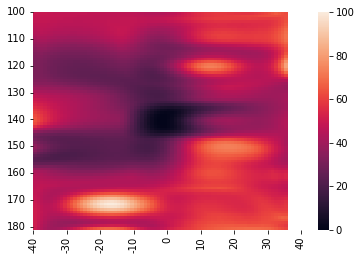

(推定マイクx座標,推定マイク高さ,z)0cm,138cm,98cm


In [121]:
import wave
import scipy as sp
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.fftpack import fft
import scipy.signal as sg
from scipy import signal
import pandas as pd
import scipy.interpolate as itpl
import resampy
import math
import seaborn as sns

#信号読み込み
#データベース生成
#測位

def chirp_exp(numSamples, chirpLen_s, start_Hz, stop_Hz, phase_rad):
    # チャープの生成関数,chirpaは生成したチャープ信号の配列を返す
    times_s = np.linspace(0, chirpLen_s, numSamples) # Chirp times.
    k = (stop_Hz - start_Hz) / chirpLen_s # Chirp rate.
    sweepFreqs_Hz = (start_Hz + k/2. * times_s) * times_s
    chirpa = np.array(np.exp(phase_rad*1j-2*np.pi*1j*sweepFreqs_Hz))
    return chirpa

def readwav(file1):
    wr = wave.open(file1, 'r')
    # waveファイルが持つ性質を取得
    ch = wr.getnchannels()
    width = wr.getsampwidth()
    fr = wr.getframerate()
    fn = wr.getnframes()
    data = wr.readframes(wr.getnframes())
    wr.close()
    X = np.frombuffer(data, dtype=np.int16)
    # 波全体の時間幅
    t = np.arange(0,len(X))/int(fr)
    # 1秒間の時間幅
    t_1sec = np.arange(0,int(fr))/int(fr)
    # 時間刻み幅
    dt = 1/int(fr)
    # 開始時間の指標
    start = int(2.0/dt)
    # 終了時間の指標
    end = int(5.0/dt)
    # plt.plot(t_1sec,X_1sec)
    return X


def create_db():
    sound_db = np.zeros(144*10*81*76).reshape(81,76,144*10)
    sound_db[:,:,:] = np.nan
    speaker_height = 100
    for h in range(0,4):
        mic_deg = -40
        for i in range(0,9):
            # wav読み込み
            sound_sample = readwav('vivesound_0322/s'+str(speaker_height)+'m'+str(mic_deg)+'.wav')
            start_hz = 10000
            #最初の帯域(10~11kHz)のみfor文の外でまわしてindex_fを固定
            #チャープ信号の生成
            chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
            # 相互相関
            corr = sg.correlate(sound_sample[50000:50000+48000*3],chirp,mode='same',method='auto')
            #最大値のインデックス見つける
            index_f = corr.argmax()
            #1つ分の波の抽出
            X_1sec = sound_sample[50000+index_f-72:50000+index_f+72]
            # FFT
            #X_fft = np.abs(fft(X_1sec))
            # データベース構築
            sound_db[mic_deg+40,speaker_height-100,0:144] = X_1sec
            start_hz += 1000
            for j in range(1,10):
                #チャープ信号の生成
                chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
                # 相互相関
                corr = sg.correlate(sound_sample[50000+index_f:50000+index_f+50000],chirp,mode='same',method='auto')
                #最大値のインデックス見つける
                index = corr.argmax()
                #1つ分の波の抽出
                X_1sec = sound_sample[50000+index_f+index-72:50000+index_f+index+72]
                # FFT
                #X_fft = np.abs(fft(X_1sec))
                # データベース構築
                sound_db[mic_deg+40,speaker_height-100,0+j*144:144+j*144] = X_1sec
                start_hz += 1000
            mic_deg += 10
        speaker_height += 25

    #ここから秋間補間，マイク方位で補間した後スピーカ高さで補間
    Akima = np.zeros(144*10*81*76).reshape(81,76,144*10)
    Akima[:,:,:] = np.nan
    #マイク方位で補間
    count = 0
    for j in range(0,4):
        sound_db_d = pd.DataFrame(sound_db[:,count,:])
        sound_db_d.astype('float64')
        Akima[:,count,:] = sound_db_d.interpolate('akima')
        count += 25

    #スピーカ高さで補間
    for i in range(0,81):
        sound_db_d = pd.DataFrame(Akima[i,:,:])
        sound_db_d.astype('float64')
        Akima[i,:,:] = sound_db_d.interpolate('akima')
    
    #Akima = pd_Zrf_d.interpolate('akima')
    print('Akima done!!')
    return Akima
    
# 残差平方和
def rss(y, t):
    f = np.sum((y-t).T*(y-t))
    return f

def normalzie(x, amin=0, amax=1):
    xmax = x.max()
    xmin = x.min()
    if xmin == xmax:
        return np.ones_like(x)
    return (amax - amin) * (x - xmin) / (xmax - xmin) + amin
#normalized_x = normalzie(x, amin=-1, amax=1)
    
def estimate(db,file):
    #データベースを読み込んで、残差平方和を計測
    rss_db = np.zeros(81*76).reshape(81,76)
    file_db = np.zeros(144*10)
    #計測データを切り抜き
    start_hz = 10000
    #最初の帯域(10kHz)のみfor文の外でまわしてindexを固定
    #チャープ信号の生成
    chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
    # 相互相関
    corr = sg.correlate(file[50000:50000+48000*3],chirp,mode='same',method='auto')
    #最大値のインデックス見つける
    index_f = corr.argmax()
    #1つ分の波の抽出
    X_1sec = file[50000+index_f-72:50000+index_f+72]
    # FFT
    #X_fft = np.abs(fft(X_1sec))
    # データベース構築
    file_db[0:144] = X_1sec
    start_hz += 1000
    for j in range(1,10):
        #チャープ信号の生成
        chirp = chirp_exp(144,0.003,start_hz,start_hz+1000,np.pi*0.5)
        # 相互相関
        corr = sg.correlate(file[50000+index_f:50000+index_f+50000], chirp, mode='same', method='auto')
        #最大値のインデックス見つける
        index = corr.argmax()
        #1つ分の波の抽出
        X_1sec = file[50000+index_f+index-72:50000+index_f+index+72]
        # FFT
        #X_fft = np.abs(fft(X_1sec))
        # データベース構築
        file_db[j*144:144+j*144] = X_1sec
        start_hz += 1000
    #print(file_db)
    #print(db)
    fft_db = abs(fft(db))
    fft_file_db = abs(fft(file_db))
    for j in range(0,81):
        for i in range(0,76):
            rss_ans = rss(normalzie(fft_db[j,i],0,1),normalzie(fft_file_db[:],0,1))
            rss_db[j,i] = rss_ans
    #print(rss_db)
    #残差平方和の値のヒートマップだすためのプログラム
   
    base = fft_db[40,38]
    for j in range(0,81):
        for i in range(0,76):
            #rss_ans = rss(normalzie(fft_db[j,i],0,1),normalzie(base[:],0,1))
            rss_ans = rss(fft_db[j,i],base[:])
            rss_db[j,i] = rss_ans
    pd.set_option('display.max_rows',100)
    pd.set_option('display.max_columns',100)
    max_rss = rss_db.max()
    rss_db = (rss_db/max_rss)*100
    dff = pd.DataFrame(rss_db)
    sns.heatmap(dff)
    plt.xticks([0, 10,20,30,40,50,60,70,80], ["-40", "-30", "-20","-10", "0", "10", "20", "30", "40"])
    plt.yticks([0, 10,20,30,40,50,60,70,80], ["100", "110", "120","130", "140", "150", "160", "170", "180"])
    plt.show()
    ''' '''
    
    #x = np.linspace(0, 50000, 1440)
    #plt.plot(x,fft_db[80,0])
    #plt.plot(x,fft_db[0,75])
    #plt.plot(x,fft_db[80,75])
    
    plt.show()
    ####ヒートマップここまで
    
    estimate_mic_speaker = np.unravel_index(np.argmin(rss_db), rss_db.shape)
    estimate_mic_speaker = list(estimate_mic_speaker)
    #全帯域のチャープ組み合わせた信号を生成
    chirp_all = chirp_exp(144,0.003,10000,11000,np.pi*0.5)
    create_hz = 11000
    for i in range(1,10):
        chirp_all += chirp_exp(144,0.003,create_hz,create_hz+1000,np.pi*0.5)
        create_hz += 1000
    #方位,estimate_mic_speaker[0]-40
    #print('方位'+str(estimate_mic_speaker[0]-40))
    #マイク高さ,estimate_mic_speaker[1]
    #距離,
    distance = (100.0*max(np.abs(sg.correlate(db[estimate_mic_speaker[0],estimate_mic_speaker[1],0:144],chirp_all, mode='same', method='auto'))))/max(np.abs(sg.correlate(file_db[0:144],chirp_all, mode='same', method='auto')))
    print('(推定マイクx座標,推定マイク高さ,z)'+str(int(math.sin(estimate_mic_speaker[0]-40)*distance))+'cm,'+str(int(estimate_mic_speaker[1]+100))+'cm,'+str(int(abs(math.cos(estimate_mic_speaker[0]-40)*distance)))+'cm') 

if __name__ == '__main__':
    #データベース作成
    db1 = create_db()
    #計測信号読み込み
    signal = readwav('vivesound_0322/test6.wav')
    # 最小二乗法によって測位
    estimate(db1,signal)

In [ ]:
(推定マイクx座標,推定マイク高さ,z)-134cm,119cm,151cm,38cm,168cm,126cm
(推定マイクx座標,推定マイク高さ,z)32cm,165cm,49cm,-34cm,158cm,158cm
(推定マイクx座標,推定マイク高さ,z)39cm,175cm,88cm,-75cm,146cm,160cm
(推定マイクx座標,推定マイク高さ,z)11cm,172cm,13cm,3cm,133cm,119cm
(推定マイクx座標,推定マイク高さ,z)-23cm,100cm,82cm,1cm,112cm,106cm
(推定マイクx座標,推定マイク高さ,z)43cm,145cm,37cm,-29cm.114cm,132cm